# Permite graficar una función de aptitud para ser utilizada con la librería DEAP
Disponible en https://deap.readthedocs.io/en/master/

In [1]:
#@title Instalar librerías
!pip install deap

# instala paquetes gráficos
##!apt-get install -y graphviz-dev
##!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.9 MB/s eta 0:00:00


In [2]:
#@title Cargar librerías
import numpy as np
import pandas as pd
import random

from deap import base
from deap import creator
from deap import tools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import ipywidgets as widgets
from ipywidgets import Box, Layout, IntSlider, Button, Checkbox
from ipywidgets import GridBox, Layout
from IPython.display import clear_output

print("\nLibrerías importadas")


Librerías importadas


In [3]:
#@title PARÁMETROS

#@markdown Parámetros de la Factorización:

# el número a aproximar
VALOR_A_APROXIMAR =  66#@param {type:"integer"}

# parámetros para el cromosoma
VALORES_PRIMOS = "2,3,5,7,11" #@param {type:"string"}
PRIMOS_CON_EXPONENTE = [int(v) for v in VALORES_PRIMOS.split(",")]

VALOR_MAXIMO_EXPONENTE = 3 #@param {type:"integer"}


In [4]:
#@title FUNCIÓN DE APTITUD Y ESTRUCTURA DEL CROMOSOMA

#@markdown > Función de Aptitud:
Version_Funcion_Aptitud = "v1" #@param ["v1", "v2"]
#@markdown - Hay 2 versiones disponibles (ambas maximizan):
#@markdown   -  v1: determina la aptitud como la diferencia entre 100% menos el error relativo entre el valor a aproximar y el del individuo  (el mejor debería ser 100%).
#@markdown   -  v2: determina la aptitud como la proporción de exponentes bien definidos en el individuo conta la cantidad mal definidos porque están de más o menos en el individuo (esto se calcula analizando el resto con el valor a aproximar).
import math

## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

creator.create("Fitness", base.Fitness, weights=(1.0,))

# definimos la función de aptitud a evaluar v1
def funcAptitud_v1(individuo):
    # calcula el número que corresponde al individuo
    valorIndividuo = formatearIndividuo(individuo, devStr=False)
    # calcula el error relativo
    if VALOR_A_APROXIMAR != 0:
      errorRelativo = abs(VALOR_A_APROXIMAR - valorIndividuo) / VALOR_A_APROXIMAR
    else:
      errorRelativo = abs(VALOR_A_APROXIMAR - valorIndividuo) / 0.000001
    # ajuste para el cálculo de aptitud para no asignar valores negativos
    # (genera problema con métodos de selección)
    if errorRelativo >= 1:
      auxLog = math.log(errorRelativo)
      if auxLog != 0:
        aptitud = 1.0 / math.log(errorRelativo)
      else:
        aptitud = 0.0
    else:
      aptitud = 100.0 - (errorRelativo*100.0)
    return aptitud,



# función para mostrar individuo
def formatearIndividuo(individuo, devStr=True, inclTotal=True):
    # calcula el número que corresponde al individuo
    strIndividuo = ""
    valorIndividuo = 1
    for i in range(len(individuo)):
      p = PRIMOS_CON_EXPONENTE[i]
      valorIndividuo = valorIndividuo * ( p ** individuo[i] )
      if (individuo[i] > 0):
        if len(strIndividuo)>0:
          strIndividuo = strIndividuo + " x "
        strIndividuo = strIndividuo + str(p) + "^" + str(individuo[i])
    # determina el resultado
    if devStr:
      if strIndividuo == "":
        res = "1"
      else:
        res = strIndividuo
      if inclTotal:
        res = res + " = " + str(valorIndividuo)
    else:
      res = valorIndividuo
    return res


# definimos la función de aptitud a evaluar v2
# cuenta la cantidad de exponentes bien definidos
# comparandolo contra la cantidad mal definidos
# (que sobran y faltantes)
def funcAptitud_v2(individuo):
    cantRtdos = [0, 0, 0]
    for i in range(len(individuo)):
      # recorre la lista de primos asignados a los exponentes
      p = PRIMOS_CON_EXPONENTE[i]
      e = individuo[i]
      # prueba desde mayor exponente posible al menor
      for j in range(VALOR_MAXIMO_EXPONENTE, 0, -1):
        resto = (VALOR_A_APROXIMAR % (p ** j))
        if (resto == 0):
          # si no tiene resto
          if (e == j):
            # y está usado en el individuo
            # se considera  OK
            cantRtdos[0] += j
            ##print(VALOR_A_APROXIMAR, p, j, resto, "ok")
            break
          else:
            # sino está mal (falta)
            cantRtdos[1] += 1
            ##print(VALOR_A_APROXIMAR, p, j, resto, "mal")
        else:
          if (e == j):
            # y está usado en el individuo
            # se considera mal (sobra)
            cantRtdos[2] += j
            ##print(VALOR_A_APROXIMAR, p, j, resto, "mal")
            break
    ##print(cantRtdos, np.sum(cantRtdos))
    aptitud = cantRtdos[0]*100.0/np.sum(cantRtdos)
    return aptitud,


# registra la función que se va a evaluar
if Version_Funcion_Aptitud == "v1":
  toolbox.register("evaluate", funcAptitud_v1)
else:
  toolbox.register("evaluate", funcAptitud_v2)


# función para mostrar aptitud
def formatearAptitud(fitness):
    return round(fitness, 3)


print("\nFunción de Aptitud definida")

#@markdown > Estructura del Cromosoma:
#@markdown - indica que es una lista de valores enteros (para simplificar la representación del problema).
# indica que los individuos son una lista de genes que aplica la función antes definida
creator.create("Individual", list, fitness=creator.Fitness)

# indica que los genes son int correspondiente a las exponentes a encontrar
toolbox.register("attr_int", random.randint, 0, VALOR_MAXIMO_EXPONENTE)

# registra el tipo de individuo y población a usar
cant_genesCromosoma = len(PRIMOS_CON_EXPONENTE)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, cant_genesCromosoma)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = 100.0



print("\nCromosoma definido")


Función de Aptitud definida

Cromosoma definido


In [5]:
#@title GENERAR INDIVIDUOS con APTITUD

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_GRAFICAR = 2500  #@param {type:"slider", min:10, max:10000, step:10}
if CANT_INDIVIDUOS_GRAFICAR < 10:
  CANT_INDIVIDUOS_GRAFICAR = 10

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_GRAFICAR)

if len(indivPobla) == 0:
   raise Exception("ERROR: Población de Individuos no definida!")

# determina cantidad de genes disponibles
cantGenes = len(indivPobla[0])

# Asigna el valor de aptitud de  los individuos
poblaAptitud = []
fitnesses = list(map(toolbox.evaluate, indivPobla))
for ind, fit in zip(indivPobla, fitnesses):
    poblaAptitud.append( fit[0] )

# Crea DF a partir de los datos

# agrega columnas de los genes
colValues = ["Gen-"+str(i) for i in range(1, cantGenes+1)]
colNoValues = []
ndf = pd.DataFrame([ind for ind in indivPobla],
                  columns = colValues)

# agrega columnas con la aptitud
atributo_clase = 'Aptitud'
ndf.insert(cantGenes, atributo_clase, poblaAptitud)

# determina rango de valores para cada columna
rangoValoresGen = {}
for col in colValues:
  rangoValoresGen[col] =[ndf[col].min(), ndf[col].max()]
rangoValoresGen[atributo_clase] =[ndf[atributo_clase].min(), ndf[atributo_clase].max()]


# muestra DF
print("\n> Vista previa de los datos de los invididuos generados: ")
ndf



> Vista previa de los datos de los invididuos generados: 


,Gen-1,Gen-2,Gen-3,Gen-4,Gen-5,Aptitud
0,3,2,0,3,0,0.168860
1,2,2,1,1,2,0.129123
2,0,0,0,3,0,0.697174
3,1,2,1,0,1,0.378923
4,1,2,1,1,0,0.466114
...,...,...,...,...,...,...
2495,2,0,2,2,1,0.149165
2496,2,0,0,3,2,0.127718
2497,0,2,3,2,2,0.086779
2498,3,3,0,3,3,0.070338


In [6]:
#@title Mostrar Estadísticas Generales de Individuos Generados { run: "auto" }

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# devuelve listas de columnas numéricas y no numéricas
def devolNombreColumnas(ndf):
  colValues = []
  colNoValues = []
  for col in ndf.columns:
    if ndf[col].dtypes in ("object", "bool"):
      colNoValues.append( col )
    else:
      colValues.append( col )
  return colValues, colNoValues

# función auxiliar para separar datos de entrada y de salida
def separarDatosXY(ndf, atributo_clase="", xSoloNros=True):
  # hace una copia auxiliar del data frame
  cdf = ndf.copy()
  # saca el atributo clase (OPCIONAL)
  if atributo_clase == "":
    Y = []
  else:
    # datos atributo clase
    Y = np.array( cdf.pop(atributo_clase).fillna("-NAN-") )
  if xSoloNros:
    # se queda sólo con los atributos numéricos (OPCIONAL)
    for col in cdf.columns:
      if cdf[col].dtypes == "object":
          cdf.pop( col )
  # datos de entrada
  X = np.array(cdf.fillna(0.001))
  return X, Y, np.array(cdf.columns)

def convColsNumericas(ndf, atributos_no_convertir = []):
  # hace una copia auxiliar del data frame
  cdf = ndf.copy()
  # convierte todas las no numéricas a numéricas (OPCIONAL)
  for col in cdf.columns:
    if col not in atributos_no_convertir:
      if cdf[col].dtypes == "object":
        # genera diccionario de valores
        valores = cdf[col].unique()
        diccValores = dict(zip(valores, range(len(valores))))
        # realiza el reemplazo
        cdf[col] = cdf[col].map(lambda s: diccValores.get(s) if s in diccValores else s)
  return cdf

# función auxiliar
def generar_estadisticas_detalladas(orDF, titulo=""):
  # título
  print("\n", titulo, ": ")
  # obtiene las estadísticas generales
  estDF = orDF.describe().transpose()
  #  genera y formatea las estadísticas
  if "min" in estDF and "max" in estDF:
    rangoValores = "[ " + estDF["min"].apply('{:.2f}'.format) + " ; " + estDF["max"].apply('{:.2f}'.format) + " ]"
  else:
    rangoValores = estDF["unique"].fillna(0.0).apply('{:.0f}'.format)
  rangoValores.name = "Rango Valores"
  # para campos no numéricos muestra las cantidades por valor
  for col in orDF.columns:
    if orDF[col].dtypes in ("object", "bool"):
      auxStr = str( orDF[col].value_counts() ).replace("\n", " ; ")
      if (auxStr.index("Name")-3) > 0:
        # saca lo del final porque no sirve
        auxStr = auxStr[:auxStr.index("Name")-3]
      rangoValores[col] = "{ " + auxStr + " }"
  if "mean" in estDF and "std" in estDF:
    promValores = estDF["mean"].fillna(0.0).apply('{:.3f}'.format) + " ± " + estDF["std"].fillna(0.0).apply('{:.3f}'.format)
  else:
    promValores = estDF["count"].apply('{:.0f}'.format)
  promValores.name = "Promedio ± Desvío"
  # obtiene valores "ceros" y nulos
  ##zero_val = (orDF == 0.00).astype(int).sum(axis=0)
  ##zero_val.name = "¿Valores Ceros?"
  ##mis_val = orDF.isnull().sum()
  ##mis_val.name = "¿Valores Nulos?"
  # prepara la nueva tabla para mostrar
  nTable = pd.concat([orDF.dtypes, rangoValores, promValores], axis=1) # zero_val, mis_val
  nTable = nTable.rename( columns = {0: 'Tipo Valor',  1: 'Rango Valores', 2: 'Promedio ± Desvío' } ) # , 3: '¿Valores Ceros?', 4: '¿Valores Nulos?'
  # muestra la nueva tabla
  pd.set_option('max_colwidth', None)
  display(nTable.fillna("-"))
  print("Tiene " + str(orDF.shape[1]) + " atributos y " + str(orDF.shape[0]) + " ejemplos.")
  print("\n")
  return


# muestra las estadísticas
generar_estadisticas_detalladas(ndf, "> Estadísticas de los datos cargados")



 > Estadísticas de los datos cargados : 


,Tipo Valor,Rango Valores,Promedio ± Desvío
Gen-1,int64,[ 0.00 ; 3.00 ],1.485 ± 1.127
Gen-2,int64,[ 0.00 ; 3.00 ],1.454 ± 1.122
Gen-3,int64,[ 0.00 ; 3.00 ],1.465 ± 1.118
Gen-4,int64,[ 0.00 ; 3.00 ],1.513 ± 1.113
Gen-5,int64,[ 0.00 ; 3.00 ],1.477 ± 1.135
Aptitud,float64,[ 0.00 ; 100.00 ],2.580 ± 11.540


Tiene 6 atributos y 2500 ejemplos.




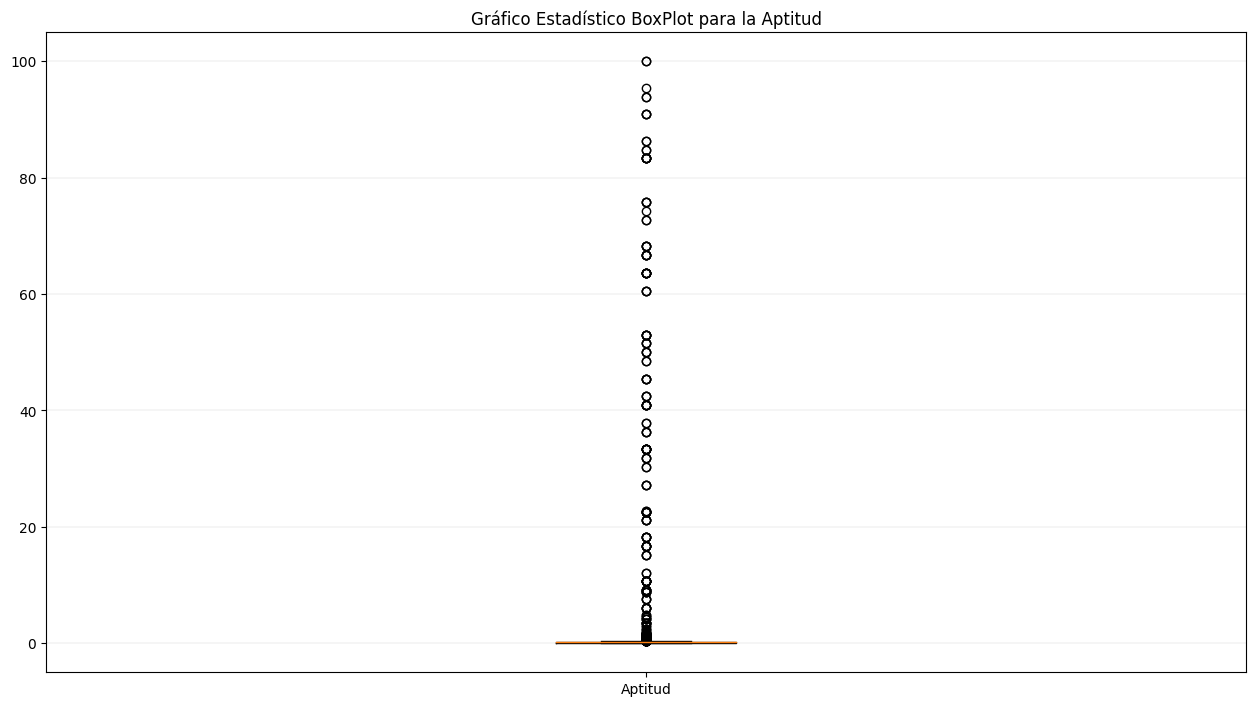

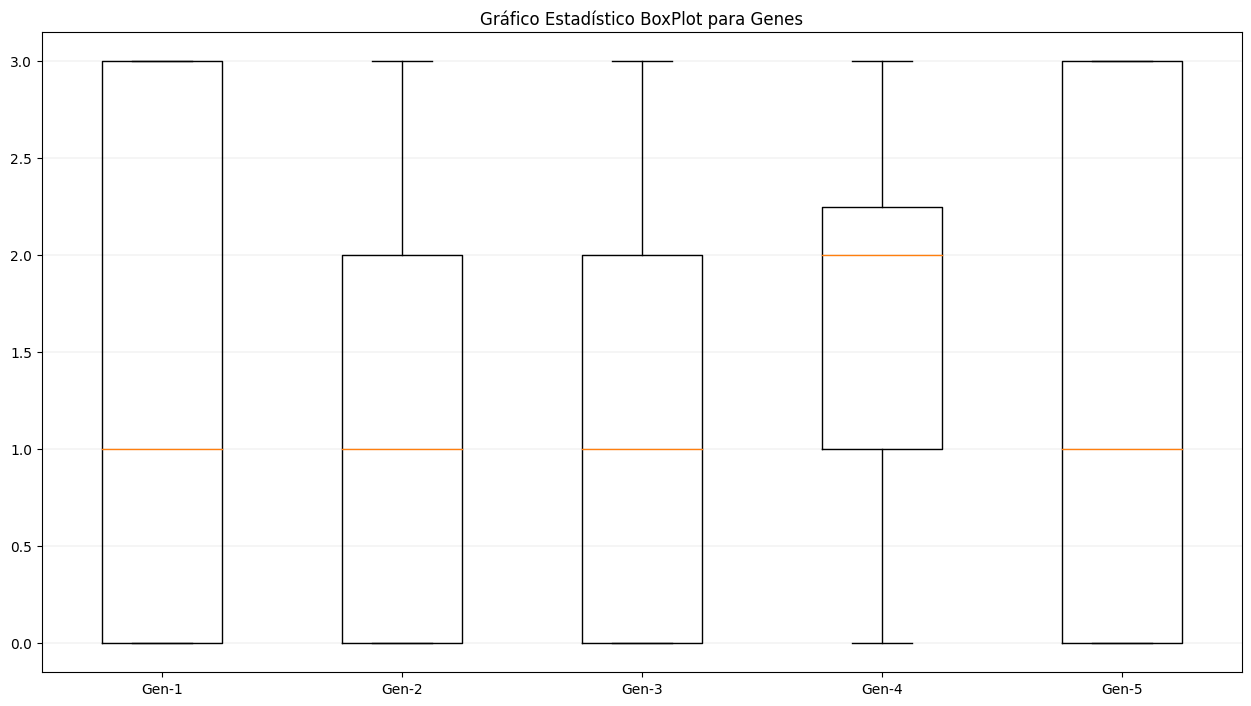

In [7]:
#@title Generar gráfico de Quartile o BoxPlot { run: "auto" }

def genGraph_BoxPlot(ndf, titulo):
  fig = plt.figure(figsize=(15,8))
  legValues = []
  colValues = []
  for col in ndf.columns:
    if ndf[col].dtypes != "object":
      legValues.append( col )
      colValues.append( ndf[col].fillna(0.001) )
  if len(colValues)>0:
    ax = fig.add_axes( [0, 0, 0.8, 0.8] )
    ax.boxplot( colValues )
    ax.set_xticklabels( legValues )
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.show()



# gráfico para aptitud
genGraph_BoxPlot(ndf[np.array([atributo_clase])], "Gráfico Estadístico BoxPlot para la Aptitud")
print("\n")
genGraph_BoxPlot(ndf[np.array(colValues)], "Gráfico Estadístico BoxPlot para Genes")




In [8]:
#@title Generar gráfico en 2D { run: "auto" }

  # agrega los combos
comboColX_2D = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Columna X:',
    disabled=False,
)
if len(colValues)>1:
  valYsel = colValues[1]
else:
  valYsel = colValues[0]

comboColY_2D = widgets.Dropdown(
    options=colValues,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

# función que genera el gráfico en 2D
def genGraph_2D(ndf, colx, coly, colz, titulo):
  if colx not in ndf or coly not in ndf or (colz!="" and colz not in ndf):
    if colx not in ndf:
      print("Nombre de columna X '" + colx + "' no existente!!")
    elif coly not in ndf:
      print("Nombre de columna Y '" + coly + "' no existente!!")
    elif (colz!="" and colz not in ndf):
      print("Nombre de columna Z '" + colz + "' no existente!!")
    return
  # define los datos para generar el gráfico
  rX = np.arange(rangoValoresGen[colx][0], rangoValoresGen[colx][1]+1, 1)
  rY = np.arange(rangoValoresGen[coly][0], rangoValoresGen[coly][1]+1, 1)
  X, Y = np.meshgrid(rX, rY)
  # inicia los valores de aptitud
  Zmx = np.zeros((X.shape[0], X.shape[1]))
  Zmn = np.zeros((X.shape[0], X.shape[1]))
  Zp = np.zeros((X.shape[0], X.shape[1]))
  zMaxDF = ndf[colz].max()
  zMinDF = ndf[colz].min()
  # completa los valores de aptitud
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      # filta los registros de acuerdo a los valores X, Y
      auxDF = ndf[ (ndf[colx]==X[i][j]) & (ndf[coly]==Y[i][j]) ]
      # calcula max, min y promedio
      Zmx[i][j] = auxDF[colz].max()
      Zmn[i][j] = auxDF[colz].min()
      Zp[i][j]  = auxDF[colz].mean()


  # determina tamaño de la figura
  fig = plt.figure(figsize=(35,20))
  # Genera el tipo de gráfico
  ax = fig.add_subplot(111)

  # Superficie colores 2D (contourf) para promedio
  plt.contourf(X, Y, Zp,  cmap=cm.RdYlGn)

  # Scatter para mínimo y máximo
  # (solo significativo por diferir en más del doble / menos de un cuarto )
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      if Zmx[i][j] == zMaxDF:
        # si es el máximo general
        ax.scatter(i, j, color='darkgreen', s=300)
      elif Zmn[i][j] == zMinDF:
        # si es el mínimo general
        ax.scatter(i, j, color='darkred', s=300)
      else:
        auxProm = Zp[i][j]
        if auxProm == 0:
          auxProm = 0.01
        auxPorc = Zmx[i][j] * 100 / auxProm
        if auxPorc > 200:
          # si es el máximo es significativo
          ax.scatter(i, j, color='darkgreen', s=100)
        else:
          auxPorc = Zmn[i][j] * 100 / auxProm
          if auxPorc <= 25:
            # si es el mínimo es significativo
            ax.scatter(i, j, color='darkred', s=100)
  #  plt.tight_layout()
  ax.set_xlabel(colx, fontsize=22)
  plt.xticks(rX, fontsize=20)
  ax.set_ylabel(coly, fontsize=22)
  plt.yticks(rY, fontsize=20)
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.1)
  plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.1)
  plt.show()


def cambiaSeleccion_2D(x, y):
  # llama a la función
  # para generar el gráfico con las columnas seleccionadas
  tit = "Gráfico en 2D de la Aptitud:"
  print(tit)
  genGraph_2D(ndf, x, y, atributo_clase, tit)
  print("(NOTA: color más ROJO significa PEOR aptitud, y más VERDE es MEJOR aptitud)")


ui2D = widgets.HBox([comboColX_2D, comboColY_2D])
out2D = widgets.interactive_output(cambiaSeleccion_2D, {'x':comboColX_2D, 'y':comboColY_2D})
display(ui2D, out2D)


Output()

GridBox(children=(Dropdown(description='Columna X:', options=('Gen-1', 'Gen-2', 'Gen-3', 'Gen-4', 'Gen-5'), va…

Gráfico en 3D de la Aptitud:


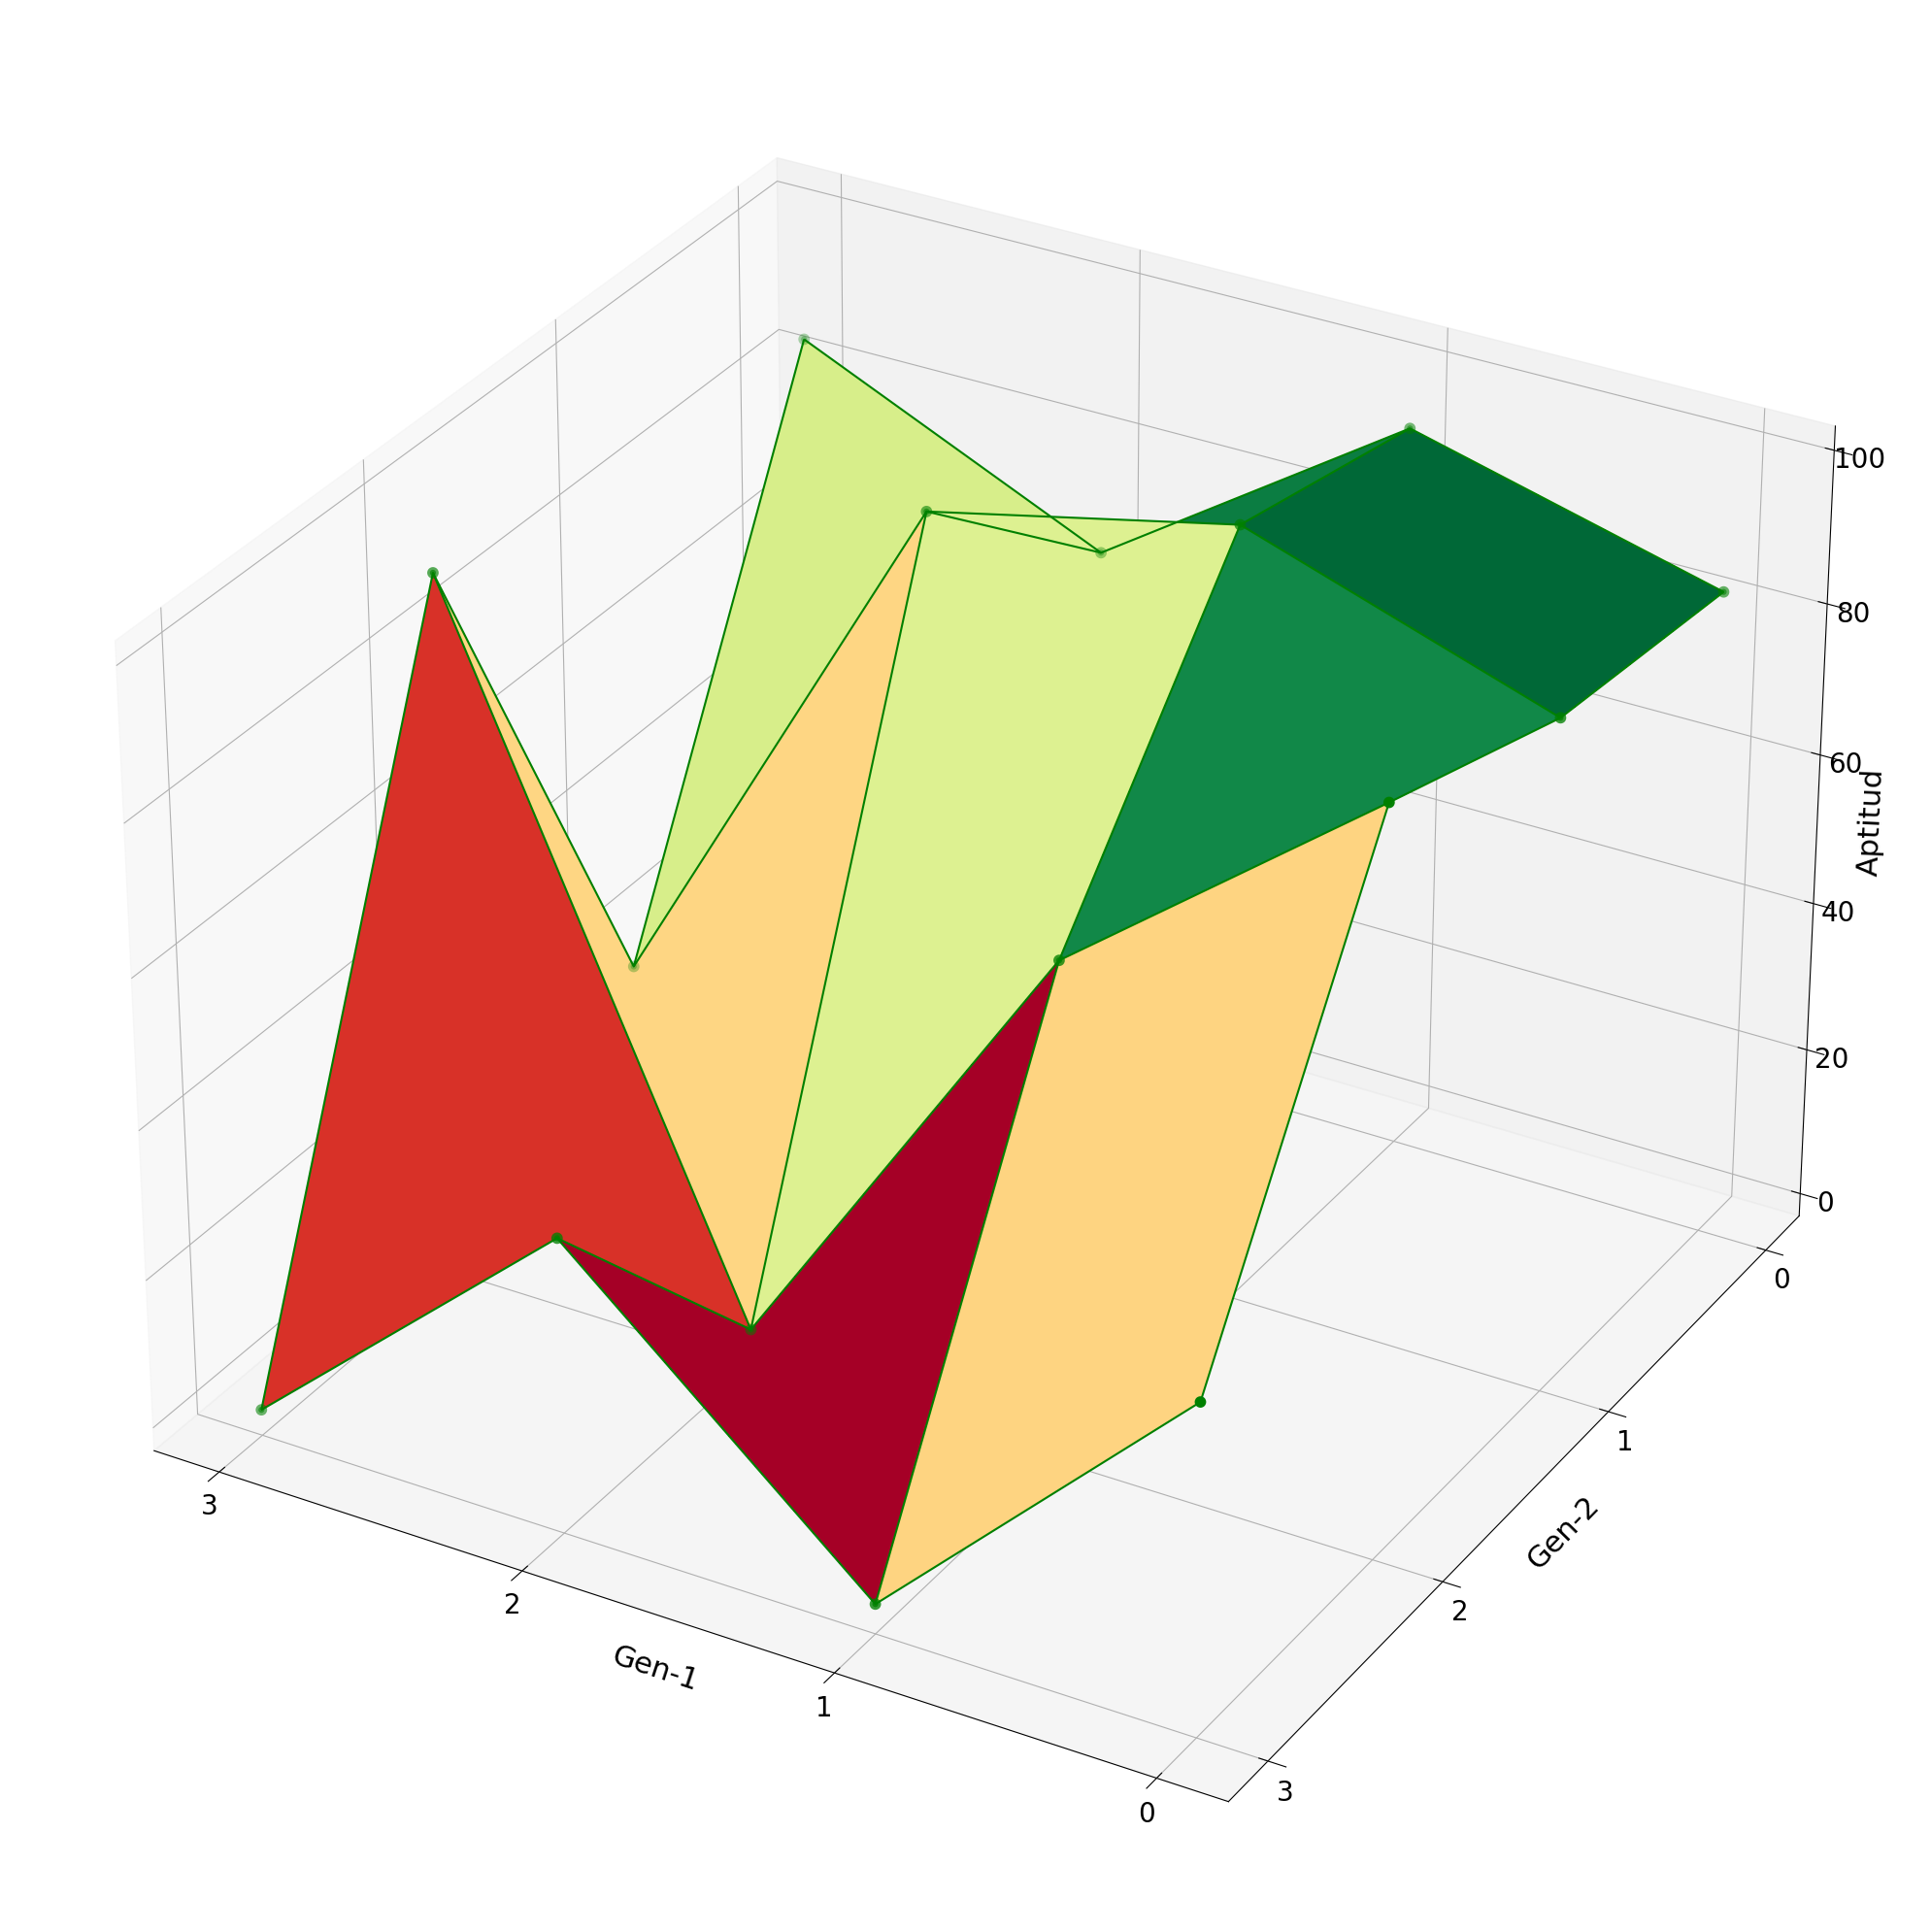

(NOTA: color más ROJO significa PEOR aptitud, y más VERDE es MEJOR aptitud)


In [9]:
#@title Generar gráfico en 3D { run: "auto" }

  # agrega los combos
comboColX_3D = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Columna X:',
    disabled=False,
)
if len(colValues)>1:
  valYsel = colValues[1]
else:
  valYsel = colValues[0]

comboColY_3D = widgets.Dropdown(
    options=colValues,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

style_3D = {'description_width': 'initial'}
rotXY_3D = IntSlider(description='Giro ejes XY', style=style_3D, min=0, max=360, value=120, step=5)
rotZ_3D = IntSlider(description='Elevación eje Z', style=style_3D, min=-360, max=360, value=30, step=5)

cbMMinProm_3D = widgets.Checkbox(
    value=False,
    description='Graficar Promedios y Mínimos de Aptitud', style=style_3D)


btnRefresh_3D = widgets.Button(
    description='Refrescar'
)

ui3D = GridBox(children=[comboColX_3D, comboColY_3D, rotXY_3D, rotZ_3D, cbMMinProm_3D, btnRefresh_3D],
        layout=Layout(
            width='100%',
            grid_template_rows='auto auto auto auto auto',
            grid_template_columns='50% 50%',
            grid_template_areas='''
            "comboColX_3D comboColY_3D"
            "rotXY_3D rotXY_3D"
            "rotZ_3D rotZ_3D"
            "cbMMinProm_3D"
            "btnRefresh_3D"
            ''')
       )
#ui = widgets.HBox([comboColX, comboColY, rotXY, rotZ])

# función que genera el gráfico en 3D
def genGraph_3D(ndf, colx, coly, colz, titulo, elev3D=None, azim3D=None, muestraDetMinProm=False):
  if colx not in ndf or coly not in ndf or (colz!="" and colz not in ndf):
    if colx not in ndf:
      print("Nombre de columna X '" + colx + "' no existente!!")
    elif coly not in ndf:
      print("Nombre de columna Y '" + coly + "' no existente!!")
    elif (colz!="" and colz not in ndf):
      print("Nombre de columna Z '" + colz + "' no existente!!")
    return
  # define los datos para generar el gráfico
  rX = np.arange(rangoValoresGen[colx][0], rangoValoresGen[colx][1]+1, 1)
  rY = np.arange(rangoValoresGen[coly][0], rangoValoresGen[coly][1]+1, 1)
  X, Y = np.meshgrid(rX, rY)
  # inicia los valores de aptitud
  Zmx = np.zeros((X.shape[0], X.shape[1]))
  Zmn = np.zeros((X.shape[0], X.shape[1]))
  Zp = np.zeros((X.shape[0], X.shape[1]))
  zMaxDF = ndf[colz].max()
  # completa los valores de aptitud
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      # filta los registros de acuerdo a los valores X, Y
      auxDF = ndf[ (ndf[colx]==X[i][j]) & (ndf[coly]==Y[i][j]) ]
      # calcula max, min y promedio
      Zmx[i][j] = auxDF[colz].max()
      if muestraDetMinProm:
        Zmn[i][j] = auxDF[colz].min()
        Zp[i][j]  = auxDF[colz].mean()

  # determina tamaño de la figura
  fig = plt.figure(figsize=(35,20))
  # Genera el tipo de gráfico
  ax = fig.add_subplot(111, projection='3d')

  if muestraDetMinProm:
    # Wireframe 3D y Scatter 3D para mínimo y promedio
    ax.plot_wireframe(X, Y, Zp, color='blue', rstride = 1, cstride = 1)
    ax.scatter3D(X, Y, Zp, marker='o', color='blue', linewidths=4)
    ax.plot_wireframe(X, Y, Zmn, color='red', rstride = 1, cstride = 1)
    ax.scatter3D(X, Y, Zmn, marker='o', color='red', linewidths=4)
  else:
    # Surface 3D para el máximo
    surf = ax.plot_surface(X, Y, Zmx, cmap=cm.RdYlGn,
                          linewidth=1, antialiased=False)

  # Wireframe 3D y Scatter 3D para máximo (siempre lo marca)
  ax.plot_wireframe(X, Y, Zmx, color='green', rstride = 1, cstride = 1)
  ax.scatter3D(X, Y, Zmx, marker='o', color='green', linewidths=4)

  # detaca el máximo general
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      if Zmx[i][j] == zMaxDF:
        # si es el máximo general
        ax.scatter3D(i, j, Zmx[i][j], marker='o', color='darkgreen', s=300)

  plt.tight_layout()
  ax.set_xlabel(colx, fontsize=22)
  plt.xticks(rX, fontsize=20)
  ax.set_ylabel(coly, fontsize=22)
  plt.yticks(rY, fontsize=20)
  ax.set_zlabel(colz, fontsize=22)
  ax.zaxis.set_tick_params(labelsize=20)
  ax.set_zlim(rangoValoresGen[colz][0]-1, rangoValoresGen[colz][1]+1)
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.1)
  plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.1)
  plt.grid(color='lightgrey', which='major', axis='z', linestyle='solid', linewidth=0.1)

  # Gira la figura 3D
  ax.view_init(elev3D, azim3D)
  plt.show()


def cambiaSeleccion(x, y, giroXY=120, elevZ=30, muestraDetMinProm=False):
  # llama a la función
  # para generar el gráfico con las columnas seleccionadas
  tit = "Gráfico en 3D de la Aptitud:"
  print(tit)
  genGraph_3D(ndf, x, y, atributo_clase, tit, elevZ, giroXY, muestraDetMinProm)
  print("(NOTA: color más ROJO significa PEOR aptitud, y más VERDE es MEJOR aptitud)")


def hacerNada():
  return

# se define esta función para que se ocupe de hacer el resfresco al tocar el botón solamente
def on_buttonRefresh_3D_clicked(b):
  clear_output()
  out3D = widgets.interactive_output(hacerNada, {})
  display(ui3D)
  cambiaSeleccion(comboColX_3D.value, comboColY_3D.value, rotXY_3D.value, rotZ_3D.value, cbMMinProm_3D.value)
btnRefresh_3D.on_click(on_buttonRefresh_3D_clicked)
on_buttonRefresh_3D_clicked(btnRefresh_3D)


In [10]:
#@title Mostrar Combinaciones con Mayor y Menor Aptitud

def mostrarEjemplosApt(ndf, tipo="max"):
  if tipo=="min":
    desc="Menor Aptitud"
  else:
    desc="Mayor Aptitud"
  print("> Combinaciones con " + desc + ":")
  # filta los registros de acuerdo a la mayor aptitud
  if tipo=="min":
    buscaApt = ndf[atributo_clase].min()
  else:
    buscaApt = ndf[atributo_clase].max()
  auxDF = ndf[ (ndf[atributo_clase]==buscaApt) ]
  display(auxDF)
  print("Hay "+ str(auxDF.shape[0]) + " ejemplos con " + desc + ".")
  print("\n")

mostrarEjemplosApt(ndf, "max")
mostrarEjemplosApt(ndf, "min")

> Combinaciones con Mayor Aptitud:


,Gen-1,Gen-2,Gen-3,Gen-4,Gen-5,Aptitud
943,1,1,0,0,1,100.0
1305,1,1,0,0,1,100.0


Hay 2 ejemplos con Mayor Aptitud.


> Combinaciones con Menor Aptitud:


,Gen-1,Gen-2,Gen-3,Gen-4,Gen-5,Aptitud
94,2,1,0,0,1,0.0
2409,2,1,0,0,1,0.0


Hay 2 ejemplos con Menor Aptitud.


